In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
!wget -O unet_dataset.zip https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb

--2019-07-12 11:28:00--  https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb
Resolving files.slack.com (files.slack.com)... 99.86.111.154
Connecting to files.slack.com (files.slack.com)|99.86.111.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134746555 (129M) [application/zip]
Saving to: ‘unet_dataset.zip’

unet_dataset.zip    100%[===================>] 128.50M  6.71MB/s    in 19s     

2019-07-12 11:28:20 (6.76 MB/s) - ‘unet_dataset.zip’ saved [134746555/134746555]



In [0]:
!unzip -qq unet_dataset.zip 

In [0]:
path = Path('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train')

In [0]:
path_img = path/'JPEGImages'
path_lbl = path/'SegmentationClassPNG'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [7]:
with open(path/'class_names.txt') as f:
  codes = np.array([line.strip() for line in f.readlines()])
codes

array(['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider'],
      dtype='<U13')

In [0]:
size = 224 # src_size # src_size // 2
bs = 32

In [0]:
import PIL

In [0]:
path_lbl_npy = path/'SegmentationClass'

In [0]:
dir_name = Path('SegmentationLabels')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def get_segmentation_label_fn(img_f):  
  label_imgname = dir_name/f'{img_f.stem}.png'
  if os.path.exists(label_imgname):
    return label_imgname
  
  npy_filename = path_lbl_npy/f'{img_f.stem}.npy'
  img = PIL.Image.fromarray(np.load(npy_filename))  
  img.save(label_imgname)
  return label_imgname

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_segmentation_label_fn, classes=codes)
      )

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats)
       )

CPU times: user 2.48 s, sys: 1.21 s, total: 3.69 s
Wall time: 8.05 s


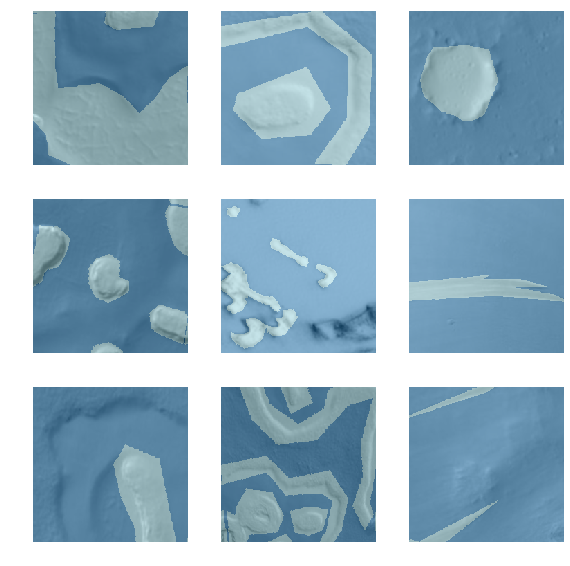

In [14]:
%%time
data.show_batch(rows=3, figsize=(8, 8))

In [15]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['_background_']
void_code

0

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [17]:
learn = unet_learner(data, models.resnet18, metrics=acc_camvid, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 99197844.03it/s]


In [18]:
from google.colab import drive
drive.mount('/content/google_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/google_drive


In [0]:
model_name = 'mars-unet-762394'
!cp 'google_drive/My Drive/Mars-Omdena/{model_name}.pth' 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/{model_name}.pth'

In [20]:
learn.load(f'{model_name}')

Learner(data=ImageDataBunch;

Train: LabelList (1387 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Valid: LabelList (287 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(

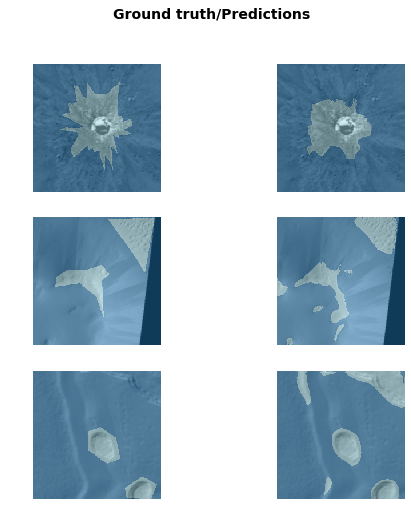

In [21]:
learn.show_results(rows=3, figsize=(8, 8))

In [23]:
!wget https://hirise-pds.lpl.arizona.edu/PDS/EXTRAS/RDR/AEB/ORB_000000_000099/AEB_000002_0000/AEB_000002_0000_RED.abrowse.jpg

--2019-07-12 11:32:10--  https://hirise-pds.lpl.arizona.edu/PDS/EXTRAS/RDR/AEB/ORB_000000_000099/AEB_000002_0000/AEB_000002_0000_RED.abrowse.jpg
Resolving hirise-pds.lpl.arizona.edu (hirise-pds.lpl.arizona.edu)... 128.196.250.179, 2607:f088:0:2::2a
Connecting to hirise-pds.lpl.arizona.edu (hirise-pds.lpl.arizona.edu)|128.196.250.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2455110 (2.3M) [image/jpeg]
Saving to: ‘AEB_000002_0000_RED.abrowse.jpg’

AEB_000002_0000_RED 100%[===================>]   2.34M  2.36MB/s    in 1.0s    

2019-07-12 11:32:12 (2.36 MB/s) - ‘AEB_000002_0000_RED.abrowse.jpg’ saved [2455110/2455110]



In [27]:
img = mpimg.imread('AEB_000002_0000_RED.abrowse.jpg')
img.shape

(4673, 2048, 3)

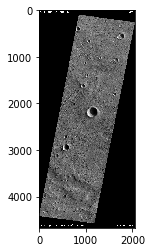

In [43]:
plt.imshow(img)

In [32]:
learn.pred_batch(data.one_item).shape

torch.Size([32, 8, 224, 224])

In [72]:
type(learn.data.train_ds[0][0])

fastai.vision.image.Image

In [0]:
!mkdir test

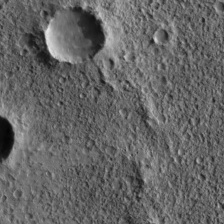

In [132]:
import PIL
img = PIL.Image.open("AEB_000002_0000_RED.abrowse.jpg")
area = (1000, 1000, 1224, 1224)
cropped_img = img.crop(area)
resized_img = cropped_img.resize((224, 224))
resized_img.save('test/test.jpg')
resized_img

In [133]:
np.array(resized_img).shape

(224, 224, 3)

In [134]:
item = torch.from_numpy(np.array(resized_img))
item.shape

torch.Size([224, 224, 3])

In [0]:
from fastai.imports import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

path = Path("test/")
img = open_image(path/'test.jpg')

classes = ['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider']
test_data = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=size).normalize(imagenet_stats)

In [0]:
pred = learn.predict(open_image(path/'test.jpg'))

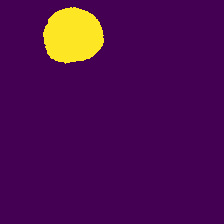

In [137]:
pred[0]

In [138]:
pred[0].shape

torch.Size([1, 224, 224])

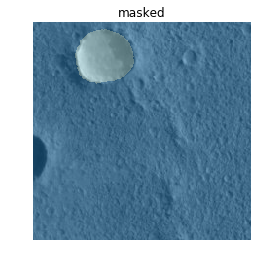

In [139]:
img = open_image('test/test.jpg')
_, ax = plt.subplots(1,1, figsize=(8,4))
img.show(ax=ax, y=pred[0], title='masked')